In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

from scipy.optimize import minimize

from pickle import dump, load

from Heston_NN import Net,weights_init

In [2]:
"""
1. Write a wrapper function.
out = model.forward(input)
2. Write a wrapper function for gradients

"""

'\n1. Write a wrapper function.\nout = model.forward(input)\n2. Write a wrapper function for gradients\n\n'

In [3]:
#model = Net()
model = Net(num_neurons=128)

#model.load_state_dict(torch.load('heston_NN_colab'))
#model = Net(num_neurons=16,device='cpu')
model.load_state_dict(torch.load('heston_NN_intermediate'))
device = model.device

model = model.double()
model.eval() # evaluation mode

Net(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
df = pd.read_csv('Heston_surface')
X = df.drop(['C_price','delta'], axis=1)
y = df[['C_price']]
input_scaler = load(open('input_scaler.pkl', 'rb'))
X_scaled =input_scaler.transform(X)
y_tensor = torch.DoubleTensor(y.values).to(device)
true_parameters = df.iloc[0][2:7]
df # k,T, C_price are given. Find v0, rho, kappa, theta, sigma

,k,T,v0,rho,kappa,theta,sigma,C_price,delta
0,-0.200000,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.433132,0.882956
1,-0.195044,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.430897,0.881005
2,-0.190113,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.428681,0.877284
3,-0.185206,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.426476,0.875320
4,-0.180323,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.424287,0.871649
...,...,...,...,...,...,...,...,...,...
95,0.186590,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.272725,0.641579
96,0.189959,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.271484,0.639545
97,0.193318,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.270251,0.637013
98,0.196664,1.0,0.481581,-0.428571,0.001,0.001,0.001,0.269025,0.635005


In [5]:
# First, we should have a dataset from a parameter set

In [6]:
#inp = np.array([np.double(np.random.uniform()) for i in range(7)]) # random tensor
inp = np.array([np.double(np.random.uniform()) for i in range(5)]) # random tensor (0,1) don't need to scale
inp[1] = np.random.uniform(0.0,0.5) # rho is usually negative
print(inp)
#inp = df.iloc[99].values

[0.38353626 0.49830022 0.75637111 0.42092161 0.64928825]


In [7]:
criterion = nn.MSELoss()

def model_wrapper(inp):
    buffer = X_scaled.copy()
    buffer[:,2:7] = inp
    tensor_buffer = torch.DoubleTensor(buffer).to(device)
    out =  model.forward(tensor_buffer).detach()
    loss = criterion(out, y_tensor)
#    num_rows = df.shape[0]
#    for index in range(num_rows):
#        row = X_scaled[index,:]
#        buffer[0:2] = row[0:2]
#        buffer[2:7] = inp[:]
#        C_price = df.iloc[index]['C_price']
#        out = model.forward(torch.tensor(buffer, dtype=torch.double).to(device)).detach().cpu().numpy()
#        loss += np.power(out[0] - C_price,2)

    return loss.detach().cpu().numpy()

In [8]:
res = minimize(model_wrapper,inp,tol=1e-8)
print('initial function ',model_wrapper(inp))
print('function value ',res.fun)
print('initial guess ',inp)
print('result ',res.x)
print('true ',X_scaled[0,2:7])
print('function with true ', model_wrapper(X_scaled[0,2:7]))

initial function  0.0020310957255305936
function value  0.0015593063824686749
initial guess  [0.38353626 0.49830022 0.75637111 0.42092161 0.64928825]
result  [0.3838439  0.48616501 0.77236151 0.41736758 0.63323451]
true  [0.71428571 0.28571429 0.         0.         0.        ]
function with true  1.2071710000137328e-05


In [9]:
print('true parameters',true_parameters.values)

true parameters [ 0.48158119 -0.42857143  0.001       0.001       0.001     ]


In [10]:
X_scaled[0,2:7]

array([0.71428571, 0.28571429, 0.        , 0.        , 0.        ])

In [11]:
solution_scaled = np.append(X_scaled[0][0:2], res.x)

In [12]:
solution = input_scaler.inverse_transform([solution_scaled])[0][2:7]
solution

array([ 0.40508563, -0.02766997, 15.44745784,  4.17425841,  9.04675494])

# Validation by known solution

In [13]:
df_val_known = df.copy()
df_val_known[df_val_known.columns[2:7]] = true_parameters.values
X_val_known = df_val_known.drop(['C_price','delta'], axis=1)
#y_val = df_val[['C_price']]
X_val_known_scaled =input_scaler.transform(X_val_known)
X_val_known_scaled = torch.DoubleTensor(X_val_known_scaled).to(device)

In [14]:
y_val_known_model = model.forward(X_val_known_scaled)
loss = criterion(y_val_known_model, y_tensor.to(device))
print(loss)

tensor(1.2072e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward>)


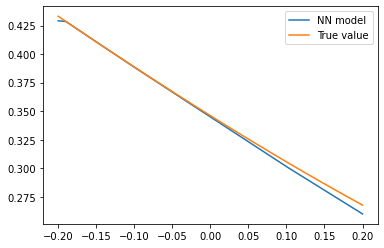

In [15]:
y_val_known_model = y_val_known_model.detach().cpu()
y_tensor = y_tensor.cpu()
plt.plot(df['k'],y_val_known_model,label='NN model')
plt.plot(df['k'],y_tensor,label='True value')
#plt.yscale('log')
plt.legend()
plt.show()

# Validation by solution

In [16]:
df_val = df.copy()
df_val[df_val.columns[2:7]] = solution # reset values
X_val = df_val.drop(['C_price','delta'], axis=1)
#y_val = df_val[['C_price']]
X_val_scaled =input_scaler.transform(X_val)
X_val_scaled = torch.DoubleTensor(X_val_scaled).to(device)

In [17]:
X_val_scaled

tensor([[-1.1102e-16,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 1.2389e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 2.4717e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 3.6985e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 4.9192e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 6.1340e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 7.3430e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 8.5461e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 9.7435e-02,  0.0000e+00,  3.8384e-01,  4.8617e-01,  7.7236e-01,
          4.1737e-01,  6.3323e-01],
        [ 

In [18]:
criterion = nn.MSELoss()
y_val_model = model.forward(X_val_scaled)
loss = criterion(y_val_model, y_tensor.to(device))
print(loss)

tensor(0.0016, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)


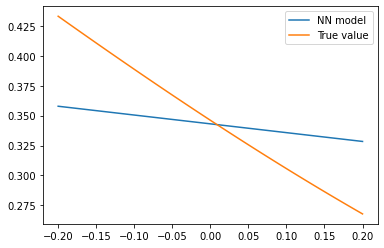

In [19]:
y_val_model = y_val_model.detach().cpu()
y_tensor = y_tensor.cpu()
plt.plot(df['k'],y_val_model,label='NN model')
plt.plot(df['k'],y_tensor,label='True value')
#plt.yscale('log')
plt.legend()
plt.show()